In [1]:
# update_qdrant_add_date.py
from qdrant_client import QdrantClient, conversions
from datetime import datetime
from typing import Optional, Dict, Any, List
import tqdm
import time
import traceback

# ====== پیکربندی ======
QDRANT_URL = "http://192.168.10.100:6333"   # یا "https://qdrant.example.com"
API_KEY = "PeH7m2rCVdB2zlsNg5HvTFFnb52DwBJK"                         # اگر نیاز دارین تو بذارین
COLLECTION = "hybrid-search"           # نام collection شما
                        # سایز batch خواندن (تجربه: 200-2000)
PAUSE_BETWEEN_BATCHES = 0.05           # برای نپُر کردن سرور
DRY_RUN = False                        # True => فقط شبیه‌سازی (نوشتن انجام نمیشه)
# ========================

client = QdrantClient(url=QDRANT_URL, api_key=API_KEY, timeout=60)

/home/mostafa/ai-projects/ticket-assistant/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_322366/4086127264.py:18: UserWarning: Api key is used with an insecure connection.
  client = QdrantClient(url=QDRANT_URL, api_key=API_KEY, timeout=60)


In [2]:
indexes = client.get_collection_aliases(collection_name=COLLECTION)
print("Indexes:", indexes)

Indexes: aliases=[]


In [3]:
client.create_payload_index(
    collection_name=COLLECTION,
    field_name="ticket_id",     # The boolean field that causes timeout
    field_schema="integer"
)

UpdateResult(operation_id=105047, status=<UpdateStatus.COMPLETED: 'completed'>)

In [38]:
BATCH = 10000 
resp = client.scroll(
            collection_name=COLLECTION,
            offset=0,
            limit=BATCH,
            with_payload=True,
            with_vectors=True
        )
points = resp[0]

In [39]:
import numpy as np
matina_vectors = np.array([point.vector['multi_matina'] for point in points])

e5_vectors = np.array([point.vector['multi_e5'] for point in points])

In [40]:
print(matina_vectors.shape)
print(e5_vectors.shape)

(10000, 1024)
(10000, 1024)


<Axes: xlabel='x', ylabel='y'>

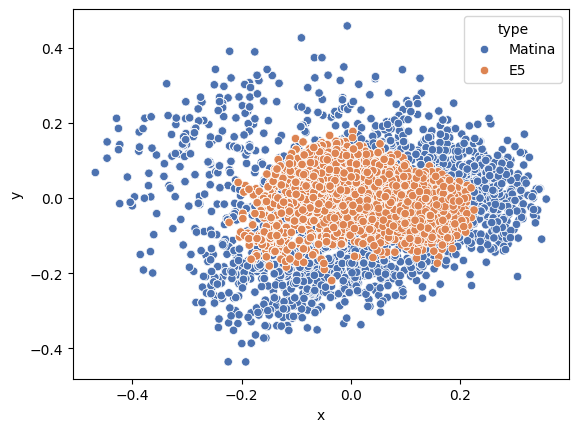

In [63]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns


model = PCA(n_components=3)
# model = TSNE(n_components=3)

m_result = model.fit_transform(matina_vectors)
e_result = model.fit_transform(e5_vectors)

result_dict = {"x":[], "y": [], "z":[], "type": []}
for m in m_result:
    result_dict['x'].append(m[0])
    result_dict['y'].append(m[1])
    result_dict['z'].append(m[2])
    result_dict['type'].append("Matina")
for e in e_result:
    result_dict['x'].append(e[0])
    result_dict['y'].append(e[1])
    result_dict['z'].append(e[2])
    result_dict['type'].append("E5")
df = pd.DataFrame(result_dict)


sns.scatterplot(result_dict, x="x", y="y", hue='type', palette="deep")

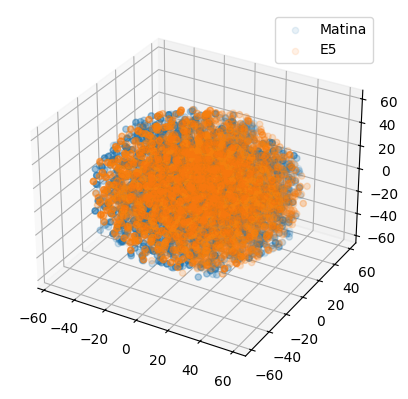

In [ ]:
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for s in df.type.unique():
    ax.scatter(df.x[df.type==s],df.y[df.type==s],df.z[df.type==s],label=s, alpha=0.1)
    
ax.legend()

<Axes: xlabel='x', ylabel='y'>

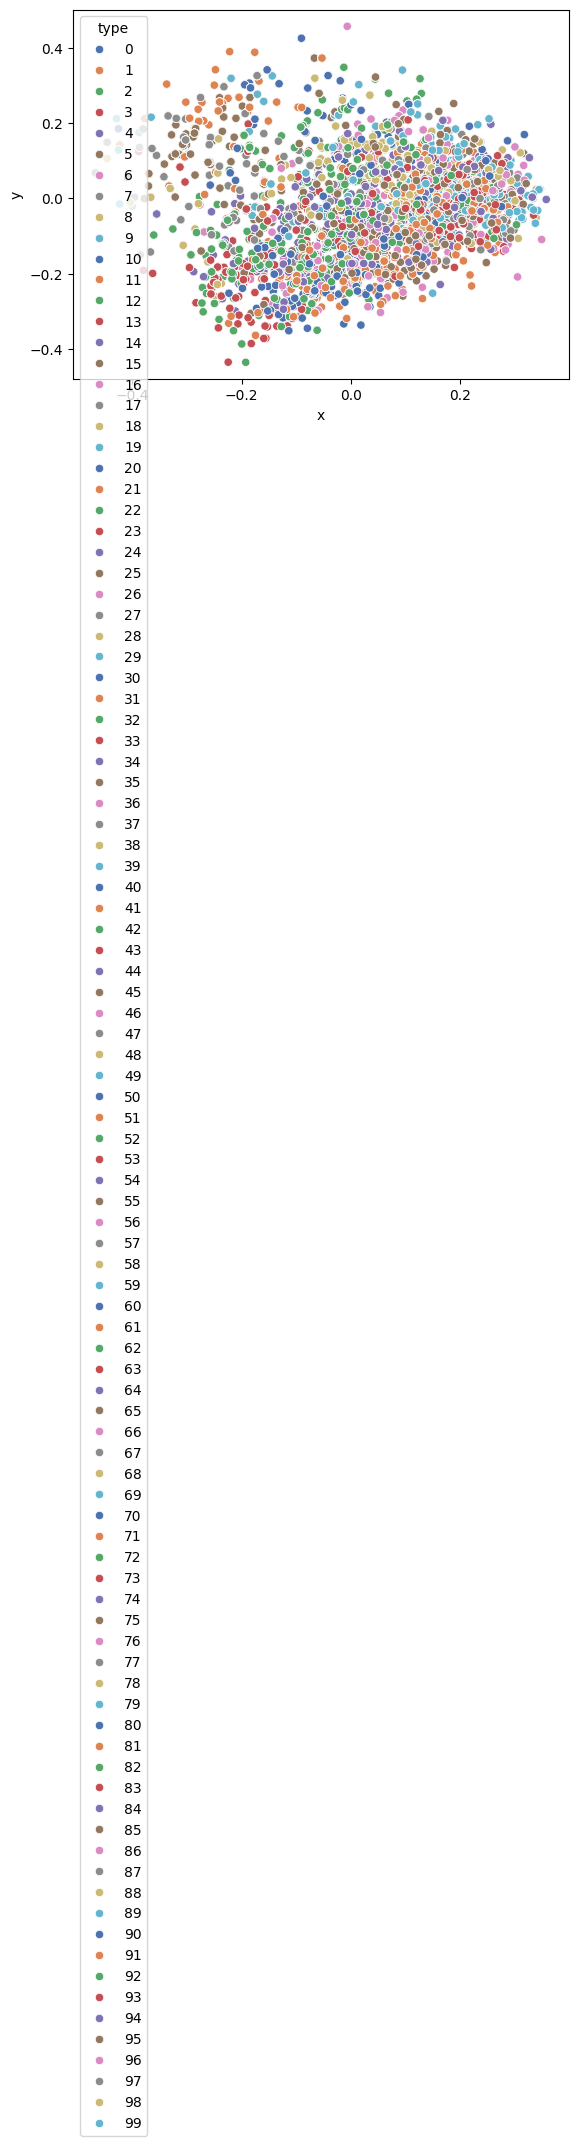

In [215]:
from sklearn.cluster import KMeans
num_clusters = 100
model = KMeans(n_clusters=num_clusters)
km_result = model.fit_predict(matina_vectors)
result_dict = {"x":[], "y": [], "z":[], "type": [], 'text': []}
for m, k, p in zip(m_result,km_result, points):
    result_dict['x'].append(m[0])
    result_dict['y'].append(m[1])
    result_dict['z'].append(m[2])
    result_dict['type'].append(k)
    result_dict['text'].append(p.payload['text'])
sns.scatterplot(result_dict, x="x", y="y", hue='type', palette="deep")

In [216]:
stopwords = []

# with open("stopwords.dat", 'r') as f:
#     for l in f.readlines():
#         stopwords.append(l.strip())
# len(stopwords)

# stopwords = stopwords + ["با", "و", "سلام", "لطفا", "درخواست", "در", "از", "احترام", "به" ,"سایت", "که", "از", "می", "تیم", "است", "انجام", "شده", "را", "شد", "شما", "ما", "این", "برای" , "تا", "ها"\
#         , "اخبار", "خبر" ,"پشتیبانی", "فنی", "فني", "تیم", "بررسی", "تيم", "های", "تشکر", "پشتيباني" , "بفرماييد", "نمایید", "اين"]\
#          + ['آید', 'توان', 'تواند', 'توانند', 'رسد', 'رود', 'سال', 'نمی', 'گوید', 'گویند'] \
#          + ["سرویس", "قسمت", "صفحه", "نصب", "صورت", "بررسي", "ارسال", "قرار"]

In [217]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
all_features = {}
df = pd.DataFrame(result_dict)
iteration = 0
while True: 
    # Example list of documents
    all_features = {}
    for i in range(num_clusters):
        documents = list(df[df['type']==i]['text'])

        # Create the TF-IDF vectorizer
        vectorizer = TfidfVectorizer(
            lowercase=True,
            stop_words=stopwords,   # removes common English words
            max_features=5,         # optional: limit to top N features
            smooth_idf=True
        )

        # Fit the model and transform the documents
        tfidf_matrix = vectorizer.fit_transform(documents)

        # Convert the result to a DataFrame for easier viewing
        df_ = pd.DataFrame(
            tfidf_matrix.toarray(),
            columns=vectorizer.get_feature_names_out()
        )
        for word in vectorizer.get_feature_names_out():
            if not all_features.get(word, False):
                all_features[word] = 0
            all_features[word] +=1

        # Display the TF-IDF scores
        # print(i, vectorizer.get_feature_names_out(), len(documents))
    flag = 0
    substopwords = []
    for i in all_features.keys():
        if all_features[i] > 2:
            substopwords.append(i)
            flag = 1
    print("iteration:", iteration, "new:", substopwords)
    stopwords += substopwords
    iteration+=1
    if not flag:
        break

iteration: 0 new: ['احترام', 'با', 'در', 'سلام', 'لطفا', 'از', 'به', 'شود', 'خبر', 'را', 'سایت', 'شده', 'این', 'کد', 'ir', 'دامنه', 'قسمت', 'می']
iteration: 1 new: ['تيم', 'درخواست', 'شد', 'فني', 'پشتيباني', 'اخبار', 'است', 'شما', 'که', 'صفحه', 'عکس', 'مورد', 'ارسال', 'پشتیبانی', 'انجام', 'برای', 'سرویس', 'های', 'طرح', 'گرافیک', 'ها', 'http', 'بررسی', 'تشکر', 'مشکل', 'امکان', 'تغییر', 'گوگل', 'com', 'iransamaneh', 'نصب', 'فایل', 'فنی', 'نمایید', 'زبان', 'نام', 'تیم', 'اعلام']
iteration: 2 new: ['باشد', 'بررسي', 'بفرماييد', 'داده', 'نمایش', 'رنگ', 'ستون', 'صورت', 'نظر', 'قرار', 'یک', '182', '94', 'دسترسی', 'ایجاد', 'بخش', 'تا', 'سرور', 'موارد', 'هم', 'ویژه', 'd8', 'آقای', 'نمی', 'آن', 'بسته', 'd9', 'تبلیغات', 'وجود', 'کنید', 'تیکت', 'برطرف', 'گزارش', 'شماره', 'ماژول', 'یا', 'جدید', 'فروش', 'رو', 'لینک', 'خانم', 'dns', 'روی', 'زیر', 'ادمین', 'آی', 'پی', 'جدول', 'سازی', 'تاریخ', 'فونت', 'استان']
iteration: 3 new: ['باز', 'مدیریت', 'اسرع', 'بالای', 'ضمیمه', 'نیز', 'وقت', 'اگر', 'حذف', 'دهی

In [218]:
for i in range(num_clusters):
    documents = list(df[df['type']==i]['text'])

    # Create the TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        lowercase=True,
        stop_words=stopwords,   # removes common English words
        max_features=5,         # optional: limit to top N features
        smooth_idf=True
    )

    # Fit the model and transform the documents
    tfidf_matrix = vectorizer.fit_transform(documents)

    # Convert the result to a DataFrame for easier viewing
    df_ = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=vectorizer.get_feature_names_out()
    )
    for word in vectorizer.get_feature_names_out():
        if not all_features.get(word, False):
            all_features[word] = 0
        all_features[word] +=1

    # Display the TF-IDF scores
    print(i, vectorizer.get_feature_names_out(), len(documents))

0 ['برگزیده' 'تصویری' 'صوت' 'عدد' 'پربحث'] 298
1 ['تر' 'نوار' 'ورزشی' 'کنیم' 'یعنی'] 59
2 ['بایستی' 'خطا' 'داخل' 'دیده' 'مثلا'] 261
3 ['147' 'admin' 'اشکالات' 'عبور' 'کلمه'] 94
4 ['trace' 'تایپ' 'عبارت' 'فشار' 'کلید'] 108
5 ['خبرگزاری' 'طی' 'قبل' 'موضوعات' 'گروه'] 173
6 ['sitemap' 'اندازی' 'راه' 'شفاهی' 'مپ'] 115
7 ['درفت' 'فردا' 'مجلس' 'مختلف' 'نهایی'] 49
8 ['خط' 'ضمنا' 'قسمتهای' 'نمايش' 'هاي'] 98
9 ['بزرگ' 'خیلی' 'لیستی' 'کوزه' 'گر'] 105
10 ['cdn' 'files' 'rar' 'yjc' 'آتا'] 90
11 ['8c' 'a9' 'af' 'b1' 'da'] 118
12 ['فلش' 'مجله' 'مختلف' 'يك' 'گزینه'] 69
13 ['9sobh' 'advertise' 'اروپا' 'جام' 'لیگ'] 72
14 ['pdf' 'آب' 'آپلود' 'حجم' 'هوا'] 155
15 ['shatel' 'جایگزین' 'شاتل' 'صبا' 'ویژن'] 149
16 ['بوده' 'خطای' 'علی' 'میشه' 'پیغام'] 171
17 ['ارائه' 'توضیح' 'خبرنگار' 'دکمه' 'شهروند'] 171
18 ['url' 'برچسب' 'تایتل' 'تکراری' 'تگ'] 24
19 ['entekhab' 'shahab' 'ارادتمند' 'حضوری' 'کنم'] 98
20 ['امضاء' 'انتقال' 'ذکر' 'هست' 'گروه'] 42
21 ['آنالیتیک' 'آنالیز' 'اسکرول' 'سورس' 'لیستی'] 90
22 ['11' '130' '

In [199]:
for i in all_features.keys():
    if all_features[i] > 2:
        print(i)
        stopwords.append(i)

In [ ]:
stopwords.append()

['و',
 'در',
 'به',
 'از',
 'که',
 'این',
 'را',
 'با',
 'است',
 'برای',
 'آن',
 'یک',
 'خود',
 'تا',
 'کرد',
 'بر',
 'هم',
 'نیز',
 'گفت',
 'می\u200cشود',
 'وی',
 'شد',
 'دارد',
 'ما',
 'اما',
 'یا',
 'شده',
 'باید',
 'هر',
 'آنها',
 'بود',
 'او',
 'دیگر',
 'دو',
 'مورد',
 'می\u200cکند',
 'شود',
 'کند',
 'وجود',
 'بین',
 'پیش',
 'شده_است',
 'پس',
 'نظر',
 'اگر',
 'همه',
 'یکی',
 'حال',
 'هستند',
 'من',
 'کنند',
 'نیست',
 'باشد',
 'چه',
 'بی',
 'می',
 'بخش',
 'می\u200cکنند',
 'همین',
 'افزود',
 'هایی',
 'دارند',
 'راه',
 'همچنین',
 'روی',
 'داد',
 'بیشتر',
 'بسیار',
 'سه',
 'داشت',
 'چند',
 'سوی',
 'تنها',
 'هیچ',
 'میان',
 'اینکه',
 'شدن',
 'بعد',
 'جدید',
 'ولی',
 'حتی',
 'کردن',
 'برخی',
 'کردند',
 'می\u200cدهد',
 'اول',
 'نه',
 'کرده_است',
 'نسبت',
 'بیش',
 'شما',
 'چنین',
 'طور',
 'افراد',
 'تمام',
 'درباره',
 'بار',
 'بسیاری',
 'می\u200cتواند',
 'کرده',
 'چون',
 'ندارد',
 'دوم',
 'بزرگ',
 'طی',
 'حدود',
 'همان',
 'بدون',
 'البته',
 'آنان',
 'می\u200cگوید',
 'دیگری',
 'خواهد_شد',


In [118]:
vectorizer.get_feature_names_out()

array(['d8', 'آن', 'اخبار', 'ارسال', 'امکان', 'باشد', 'خبر', 'داده',
       'سرویس', 'شود', 'صفحه', 'صورت', 'قرار', 'قسمت', 'موارد', 'مورد',
       'نصب', 'نمایید', 'یا', 'یک'], dtype=object)

In [82]:
df = pd.DataFrame(result_dict)
df[df['type']==0]
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer.fit(list(df[df['type']==0]['text']))
transformer.get_feature_names_out()[:10]

ValueError: Expected 2D array, got 1D array instead:
array=['با سلام\nخواهشمند است نسبت به ارسال موارد زیر در اسرع وقت اقدام نمایید:\n۱) ساختار محتوایی صفحه نخست به همراه عرض سایت\n۲) ساختار محتوایی صفحه سرویس (در صورتی که سایت دارای صفحات سرویس است)\n* ساختار محتوایی صفحات سرویس به دو صورت میتواند باشد:\n۲.۱) لیستی: در این حالت برای صفحات سرویس قسمت خبری پیش بینی نشده و اخبار به صورت لیستی و زیر هم نمایش داده خواهند شد. کلیه اخبار ارسالی نیز در یکی از قسمت های صفحه اول سایت (که هنگام ارسال خبر انتخاب میشود) دیده خواهند شد.\nمثال: سایت برترین ها\n۲.۲)\u200c قسمتی:\u200c در این حالت به ازای هر صفحه سرویس، یکسری قسمت خبری از پیش تعیین شده به صورت خودکار ایجاد خواهد شد. در این حالت اخبار ارسالی به سرویس ها به صورت خودکار در صفحه اول نمایش داده نخواهند شد و در صفحه اول اخبار برگزیده شما توسط خود شما قرار خواهند گرفت. در صورتی که مایل به پیاده سازی صفحات سرویس از نوع قسمتی می باشید لازم است تا قسمت های موجود در سرویس و محل قرارگیری آنها را مشخص نمایید.\nمثال\u200c: سایت فردا نیوز\n۳) ساختار محتوایی صفحه خبر\n* ساختار محتوایی معمول صفحه خبر به دو صورت زیر است:\n۳.۱) متقارن: در این حالت در دو طرف متن خبر ستون تبلیغات قرار میگیرد.\n۳.۲) نامتقارن: در این حالت در یکی از ستون های صفحه خبر آخرین اخبار، پربیننده ترین و پربحث ترین و در ستون دیگر تبلیغات به نمایش در می آید.\nهمچنین به موارد زیر نیز پاسخ دهید:\n۱) سبک طرح به چه صورت باشد؟ مدرن، سنتی، یا ....؟\n۲) در صورت داشتن لوگو، لطفا فایل Psd آن را ارسال نمایید تا در طرح استفاده شود.\n۳) رنگ بندی مورد نظر خود را مشخص نمایید.\n۴) در صورت علاقمند بودن به نمونه کاری، لطفا نام آن (ها) را اعلام نمایید.\n۵) در صورت نیاز به مدیریت لوگو، لطفا اعلام نمایید.\n*مدیریت لوگو: قابلیتی است که به شما امکان تغییر لوگو را می دهد. به طور نمونه شما می توانید در مناسبت های زمانی، لوگوی خود را متناسب با آن زمان تغییر دهید.\n۶) آیا سایت شما دارای ستون تبلیغات مجزا است؟\nبا احترام\nتیم پشتیبانی فنی'
 '1. اخیار برتر(1) - سرتیتر اخبار(3ردیف 2تایی) - اخبار ویژه(15) - گزارش تصویری (4) -اخبار ویژه استان بوشهر (30) - اخبار ایران و جهان (90)- پربازدیدترین ها (15) - اقتصادی (5تا کادر عکس دار) - ورزشی (5تا کادر عکس دار) - سلامت(5تا کادر عکس دار) - گوناگون(5تا کادر عکس دار) - حوادث( 5تا کادر عکس دار)- مقالات( 8تایی) - پربحث نری (10 تایی)- نظرسنجی\n2.قسمتی\n3. نامتقارن\n4.لحظه نیوز\n6. خیر- ستون تبلیغات در صفحه کل طراحی شود'
 'سرتیتر اخبار به سلیقه خودتان باشد در صورت جالب نبودن برداشته شود\nرنگ بندی سایت فرارو و یا آبی\nتشکر'
 ...
 'خانم خالقی\nلطفا نظر خود را در خصوص این درخواست اعلام نمایید.\nبا تشکر'
 'خانم نجفی\nامکاناتی مثل سایت مپ که یک استاندار است را به صورت سفارشی برای یک مشتری اصلاح نمی توان کرد.\nبه مشتری هم اعلام شود که مورد مواردی مثل مورد شماره سه در آپدیت های بعدی در راس کارمان قرار خواهد گرفت و در صورت اجرا و تست کامل بر روی تمام سایت ها آپدیت خواهد شد'
 'با سلام\nمورد شماره ۳ جهت امکان سنجی اجرا در نسخه های بعدی نرم افزار در دستور کار قرار خواهد گرفت.\nبا احترام\nتيم پشتيباني فني'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.